<a href="https://colab.research.google.com/github/Falconwatch/cybersec_ht/blob/main/Statistical_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [225]:
import pandas as pd
from tqdm import tqdm

In [65]:
cust_1 = pd.read_excel("cust_1.xlsx")
cust_2 = pd.read_excel("cust_2.xlsx")
examples = pd.read_excel("examples.xlsx")

In [66]:
cust_1 = cust_1.rename({"c1.country_code":"country_code"}, axis=1)
cust_2 = cust_2.rename({"c2.country_code":"country_code"}, axis=1)

In [68]:
countries = cust_1["country_code"].unique()

# Соберу все возможные комбинации

In [69]:
country_datas = list()
for country in countries:
  c1 = cust_1[cust_1["country_code"] == country]
  c2 = cust_2[cust_2["country_code"] == country]
  total = c1.reset_index(drop=True).merge(c2.reset_index(drop=True),
                                          on =["country_code"])
  country_datas.append(total)

In [70]:
full_data = pd.concat(country_datas)
full_data.shape

(5073577, 13)

In [189]:
data = full_data.sample(100000).reset_index(drop=True)

# Вычислю фичи сходства

In [190]:
from difflib import SequenceMatcher
def similarity_ratio_func(df, field):
  name1 = "c1."+field
  name2 = "c2."+field
  name3 = field+"_similarity_ratio"
  df[name3] = df[[name1, name2]].apply(lambda x: 
                  SequenceMatcher(None, str(x[name1]), str(x[name2])).ratio(), axis=1)

In [191]:
feature_fields = [c[3:] for c in cust_1.columns[1:] if "country" not in c]

In [192]:
for ff in tqdm(feature_fields):
  similarity_ratio_func(data, ff)
  similarity_ratio_func(examples, ff)

100%|██████████| 5/5 [00:30<00:00,  6.18s/it]


In [193]:
features = [c for c in data.columns if "_similarity_ratio" in c]
ids = ["c1.key", "c2.key"]
features

['hotel_name_similarity_ratio',
 'city_name_similarity_ratio',
 'hotel_address_similarity_ratio',
 'star_rating_similarity_ratio',
 'postal_code_similarity_ratio']

In [194]:
features+ids

['hotel_name_similarity_ratio',
 'city_name_similarity_ratio',
 'hotel_address_similarity_ratio',
 'star_rating_similarity_ratio',
 'postal_code_similarity_ratio',
 'c1.key',
 'c2.key']

In [195]:
print(data[features].mean())
print(data[features].std())

hotel_name_similarity_ratio       0.281211
city_name_similarity_ratio        0.263801
hotel_address_similarity_ratio    0.285898
star_rating_similarity_ratio      0.707670
postal_code_similarity_ratio      0.350644
dtype: float64
hotel_name_similarity_ratio       0.121158
city_name_similarity_ratio        0.192308
hotel_address_similarity_ratio    0.116206
star_rating_similarity_ratio      0.190357
postal_code_similarity_ratio      0.236312
dtype: float64


In [196]:
print(examples[features].mean())
print(examples[features].std())

hotel_name_similarity_ratio       0.885954
city_name_similarity_ratio        0.725193
hotel_address_similarity_ratio    0.748688
star_rating_similarity_ratio      0.842407
postal_code_similarity_ratio      0.811049
dtype: float64
hotel_name_similarity_ratio       0.150168
city_name_similarity_ratio        0.336812
hotel_address_similarity_ratio    0.225613
star_rating_similarity_ratio      0.216638
postal_code_similarity_ratio      0.358966
dtype: float64


# Статистический подход

In [197]:
#Формируем ядро для оценки
means = examples[features].mean().to_dict()
stds = examples[features].std().to_dict()

In [198]:
means

{'hotel_name_similarity_ratio': 0.8859536083421033,
 'city_name_similarity_ratio': 0.7251925596262868,
 'hotel_address_similarity_ratio': 0.7486881053713478,
 'star_rating_similarity_ratio': 0.8424068767908309,
 'postal_code_similarity_ratio': 0.8110489188695829}

In [199]:
def eval_one_pair(pair):
  stats = dict()
  for f in features:
    stats[f] = (pair[f] - means[f])/stds[f]
  return stats

In [200]:
random_example = data.sample(1).iloc[0]
eval_one_pair(random_example)

{'hotel_name_similarity_ratio': -4.766270346263729,
 'city_name_similarity_ratio': -2.153110075281829,
 'hotel_address_similarity_ratio': -2.692713114910807,
 'star_rating_similarity_ratio': 0.7274483617320052,
 'postal_code_similarity_ratio': -1.5629575558543929}

In [201]:
good_example = examples.sample(1).iloc[0]
eval_one_pair(good_example)

{'hotel_name_similarity_ratio': 0.7594591540233512,
 'city_name_similarity_ratio': 0.2660901274488256,
 'hotel_address_similarity_ratio': 1.1139059663297592,
 'star_rating_similarity_ratio': 0.7274483617320052,
 'postal_code_similarity_ratio': 0.5263757045190748}

# Посмотрим распределение отклонений

In [263]:
examples_dist = pd.DataFrame(list(examples.apply(eval_one_pair, axis=1).values))
examples_dist = pd.concat([examples[ids],examples_dist], axis=1)
data_dist = pd.DataFrame(list(data.apply(eval_one_pair, axis=1).values))
data_dist = pd.concat([data[ids],data_dist], axis=1)
#examples_dist.head()
#examples_dist.plot(kind='kde', figsize=[15,10])

In [264]:
examples_dist["dataset"] = "examples"
data_dist["dataset"] = "data"

In [265]:
all_data_dist = pd.concat([examples_dist, data_dist]).reset_index(drop=True)

-3.2745437806534654


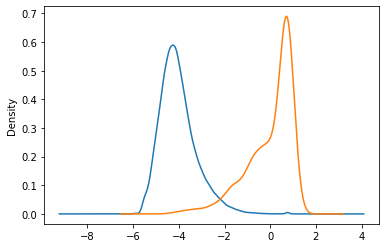

In [266]:
all_data_dist.groupby('dataset')['hotel_name_similarity_ratio'].plot(kind='kde')
print(examples_dist["hotel_name_similarity_ratio"].quantile(0.01))

-2.153110075281829


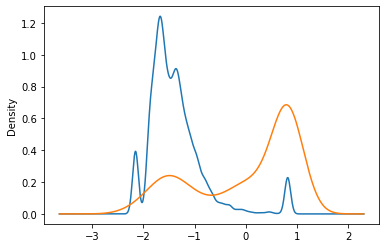

In [267]:
all_data_dist.groupby('dataset')['city_name_similarity_ratio'].plot(kind='kde')
print(examples_dist["city_name_similarity_ratio"].quantile(0.01))

-2.3532193314977254


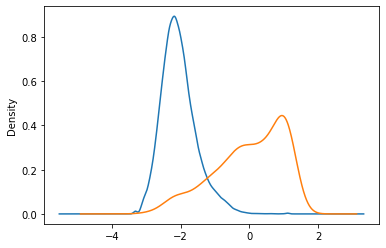

In [268]:
all_data_dist.groupby('dataset')['hotel_address_similarity_ratio'].plot(kind='kde')
print(examples_dist["hotel_address_similarity_ratio"].quantile(0.01))

-2.3498786472918707


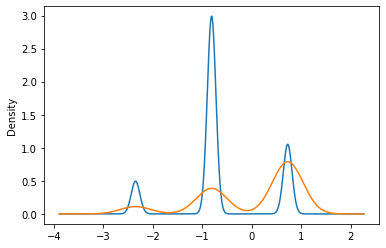

In [269]:
all_data_dist.groupby('dataset')['star_rating_similarity_ratio'].plot(kind='kde')
print(examples_dist["star_rating_similarity_ratio"].quantile(0.01))

-2.259401975978882


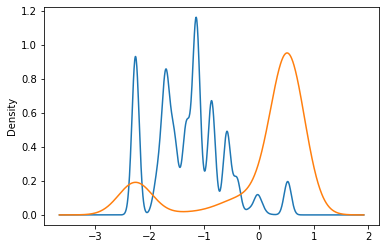

In [270]:
all_data_dist.groupby('dataset')['postal_code_similarity_ratio'].plot(kind='kde')
print(examples_dist["postal_code_similarity_ratio"].quantile(0.01))

## Множественная проверка гипотеза

In [271]:
from statsmodels.stats.multitest import multipletests
from scipy import stats

In [294]:
one_row = all_data_dist.sample(1).iloc[0]
one_row

c1.key                            780A4388052C5088FD7A6E63F285FE5A
c2.key                            622D40A3E1AB05B242FD214D081B7693
hotel_name_similarity_ratio                               -3.75162
city_name_similarity_ratio                               -1.636759
hotel_address_similarity_ratio                           -1.407957
star_rating_similarity_ratio                             -2.349879
postal_code_similarity_ratio                             -1.145091
dataset                                                       data
Name: 30328, dtype: object

In [295]:
data.loc[(data["c1.key"]==one_row["c1.key"]) &
         (data["c2.key"]==one_row["c2.key"])]

,c1.key,c1.hotel_name,c1.city_name,country_code,c1.hotel_address,c1.star_rating,c1.postal_code,c2.key,c2.hotel_name,c2.city_name,c2.hotel_address,c2.star_rating,c2.postal_code,hotel_name_similarity_ratio,city_name_similarity_ratio,hotel_address_similarity_ratio,star_rating_similarity_ratio,postal_code_similarity_ratio
29979,780A4388052C5088FD7A6E63F285FE5A,Moment House Huahin,Hua Hin / Cha-am,TH,"14/160 Pracha Samakkhi Road, Soi Moo Baan Khao...",2.5,77110,622D40A3E1AB05B242FD214D081B7693,CHERN Hostel,Bangkok,17 Soi Ratchasak Bamrung Muang Road. Samranrat...,3.0,10200,0.322581,0.173913,0.431034,0.333333,0.4


In [296]:
percentiles_for_feature=dict()
for f in one_row.index:
  if "_ratio" in f:
    percentiles_for_feature[f] = stats.percentileofscore(examples_dist[f], one_row[f])/100
percentiles_for_feature

{'hotel_name_similarity_ratio': 0.0028653295128939827,
 'city_name_similarity_ratio': 0.1002865329512894,
 'hotel_address_similarity_ratio': 0.10888252148997134,
 'star_rating_similarity_ratio': 0.04441260744985673,
 'postal_code_similarity_ratio': 0.15759312320916904}

In [299]:
multipletests(list(percentiles_for_feature.values()), 0.05)

(array([ True, False, False, False, False]),
 array([0.01424478, 0.27169605, 0.27169605, 0.16616207, 0.27169605]),
 0.010206218313011495,
 0.01)

In [231]:
examples_dist["hotel_name_similarity_ratio"].percentile()

AttributeError: ignored

In [215]:
all_data_dist


In [ ]:
all_data_dist.groupby('dataset')['postal_code_similarity_ratio'].plot(kind='kde')

## Посмотрю глазами на отдельные кейсы

In [184]:
data_dist.shape

(100000, 6)

In [185]:
data.shape

(100000, 18)

In [187]:
(data_dist["hotel_name_similarity_ratio"]>0).mean()

0.00141

In [188]:
data

,c1.key,c1.hotel_name,c1.city_name,country_code,c1.hotel_address,c1.star_rating,c1.postal_code,c2.key,c2.hotel_name,c2.city_name,c2.hotel_address,c2.star_rating,c2.postal_code,hotel_name_similarity_ratio,city_name_similarity_ratio,hotel_address_similarity_ratio,star_rating_similarity_ratio,postal_code_similarity_ratio
318839,80AEE7152500CAC10F05BD1A0AE3A791,Lynt Hotel Jakarta,Jakarta,ID,Jalan Cideng Timur No 35,3.0,10130,C2D930F1DE1FA9D785218A1E64B8F0E8,RedDoorz @ Tibubeneng Canggu,Canggu,Jl. Bantan Kangin Gg. Grandpa No. 3,2.0,80361,0.130435,0.153846,0.474576,0.666667,0.200000
764985,2FE2186DA00DFAA4BB4829CD7655EA0D,Best Western PLUS Madison Inn,Madison (FL),US,167 SE Bandit Street,2.0,32340-5916,AA2D58C37BDA289615D587309274D2EA,Best Western Roseville,Roseville,220 Harding Boulevard,2.0,95678,0.549020,0.095238,0.243902,1.000000,0.266667
22078,312E3E568C342818F387FB2989469B25,Gooding's Groves Olive Farm B&B,Franschhoek,ZA,"R45/Main Road, La Motte/Goederust, Franschhoek...",4.0,7690,15F23417B01AB7B1B598161A391C2865,Pongola Country Lodge,Pongola,14 Jan Mielie Street,0.0,3170,0.192308,0.111111,0.191304,0.666667,0.500000
869952,D4A634D64D52C558DF3F1AC57941DD38,Ploenlay,Krabi,TH,"199/42 Aonang Soi 8, Moo 3",2.0,81000,739E64478E5696A217DB017C1BA552FB,Sun Hill Hotel,Patong Beach,"245/2 Nanai Road, Kathu, Phuket",3.0,83150,0.363636,0.117647,0.350877,0.666667,0.600000
435424,84BCF7453EA1257D8FA507AD894F1249,Karon Hotel - Lajpat Nagar,New Delhi and NCR,IN,"61 Ring Road, Lajpat Nagar-3",3.5,110024,17B1E146C8EBE6A8E4BDB4D8B3687647,The Terraces,Chamba,"Kanatal, Chamba Mussorrie Highway, Tehri Garwala,",0.0,249145,0.105263,0.173913,0.259740,0.333333,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121450,71E7AAABDC8FD9334C2612AC54131612,7 Days Inn Jinan Da Ming Lake North Gate Branch,Jinan,CN,"No.5,Bei Guan North Road",2.0,NaN,4A8FE936563CEE5D88578923D9A7B028,Easy Inn Lianyue,Xiamen,No. 14 Lianyue Road,3.0,361000,0.349206,0.363636,0.511628,0.666667,0.000000
602260,BB6D3E937DAABDEBE7F048494EE0D8D6,Elara by Hilton Grand Vacations,Las Vegas (NV),US,80 East Harmon Drive,4.0,89109,7ED126119E65E99B07E83A73B5C0CB10,Quality Inn near Mountain Creek,Vernon,15 Route 94,2.0,7462,0.258065,0.200000,0.193548,0.666667,0.000000
48019,14298AA0D72EE61295A223586F8A8549,Acaill Accommodation,Adelaide,AU,"1/22 North Esplanade, Glenelg North",4.0,5045,77C561FED0FBEC92643EF18E304DE03C,Macleay Hotel,Sydney,"28 Macleay Street, Potts Point",3.5,2011,0.181818,0.285714,0.246154,0.333333,0.250000
868407,3CCD65979197E060C41A39A512800305,Hilton San Diego Airport Harbor Island Hotel,San Diego (CA),US,1960 Harbor Island Drive,3.0,92101,DCC70A9DE639EAA21961C64ECE3620CB,Econo Lodge Escanaba,Escanaba,921 North Lincoln Road,2.0,49829,0.250000,0.181818,0.347826,0.666667,0.400000


In [215]:
data[data_dist["hotel_name_similarity_ratio"]>-1.96]

,c1.key,c1.hotel_name,c1.city_name,country_code,c1.hotel_address,c1.star_rating,c1.postal_code,c2.key,c2.hotel_name,c2.city_name,c2.hotel_address,c2.star_rating,c2.postal_code,hotel_name_similarity_ratio,city_name_similarity_ratio,hotel_address_similarity_ratio,star_rating_similarity_ratio,postal_code_similarity_ratio
15,801BB2C9CD324535FA369F073B7C742E,Comfort Suites DFW Airport,Irving (TX),US,4700 W. John Carpenter Fwy.,3.0,75063,A0F9BC759FBE0CBC3FB2D046309EA67F,Comfort Suites Airport Nashville,Nashville,2521 Elm Hill Pike,2.0,37214,0.758621,0.200000,0.177778,0.666667,0.200000
18,77A7D83B81F1EE68A4F3E572F5424634,Hotel Maya Deluxe,Hyderabad,IN,"61/A, M.G.RoadRanigunj,Secunderabad.",1.0,500003,29D6E065185BEA2FA50493411A438443,Hotel Barbareek,Shillong,"Lewduh, Mawlonghat, Anjalee",2.0,793002,0.625000,0.000000,0.285714,0.666667,0.333333
120,6B029080375B069F45049F8AD027662E,Jinjiang Inn Beijing Wangfujing,Beijing,CN,"Dengshikou Street 75, Dongcheng District",2.0,NaN,C3A1BCFEC0BA1E078163BE653BFDF2B9,Jinjiang Inn Binzhou Huanghesan Road,Binzhou,"No. 498 Huanghesan Road, Binzhou, Shandong",3.0,256600,0.626866,0.428571,0.268293,0.666667,0.000000
135,DB5D05255FC54612A128D295208455A1,Villa Tiah,Bali,ID,"Jalan Kubu Anyar I No. 27, Kuta",3.0,80361,343DA985230DC487656C5972462B08F8,Villa Charlie,Kerobokan,Jl. Merta Agung,4.0,80361,0.608696,0.153846,0.217391,0.666667,1.000000
266,773EC92783AF52CB0B983C8DB4AF6085,Best Western Bastrop Pines Inn,Bastrop (TX),US,107 Hunters Crossing Boulevard,3.0,78602,C2614D5779D37454FE6F0251FA796DB7,Best Western Plus Cushing Inn & Suites,Cushing,508 East Main Street,0.0,74023,0.617647,0.105263,0.320000,0.666667,0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99696,BC620E3E3946F72C414709EE056766D2,Kingsland Hotel,London,GB,Kingsbury Circle,3.0,NW9 9RR,1ED2D0B7F797B6205B25A9CC09146BAA,Barking Park Hotel,Barking,56-60 Tanner Street,0.0,IG11 8QF,0.606061,0.153846,0.285714,0.666667,0.133333
99698,5E4EE557D601D303B902447CD363165D,MARO Hotel,Hanoi,VN,64 Cau Go,3.0,100000,04EDA7DF46FA6F5F3F5C65D1B38F6E8E,Romance Hotel,Ho Chi Minh City,"67-69 Road No.5, Pham Hung, Binh Hung, Binh Chanh",1.0,NaN,0.608696,0.285714,0.137931,0.666667,0.000000
99710,3B5C0685B7BA73A4CFCBFB6A58E0705C,Legenda Boutique Hotel,Johor Bahru,MY,"No 7 & 9, Jalan Bestari 8/2, Taman Nusa Bestar...",2.0,79150,386CAC07A84CE7A75D7C8D551FD8AD5E,Ipoh Boutique Home,Ipoh,"20, Lebuh Tasek Timur 2, Kampung Bercham",0.0,31400,0.650000,0.266667,0.226804,0.666667,0.400000
99800,F64D8FCDC83C5EEA30B8E0542541F7CF,Lavy Hotel,Dalat,VN,"2B Lu Gia, Ward 9",3.0,NaN,21B73232797DFF519D384C251EB70618,Blue Heaven Hotel,Nha Trang,43 - 44 Nguyen Tat Thanh,2.0,NaN,0.592593,0.285714,0.292683,0.666667,1.000000
